In [6]:
import sys
print(sys.executable)

/opt/homebrew/Caskroom/miniconda/base/bin/python


In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from pickle import dump, load
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [8]:
# Define function to load images
def load_images(images_folder, save_file_to=None):
    X_original = []
    X = []
    y = []
    
    for subdir, dirs, files in os.walk(images_folder):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                
                image = Image.open(img_path).convert('L')
                image = image.resize((48, 48))
                X_original.append(np.array(image).flatten())
                X.append(np.array(image).flatten())
                y.append(label)
    
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_original, X, y), f, protocol=5)
    
    return np.array(X_original), np.array(X), np.array(y)

# Define paths
images_folder = '../images'
dataset_file = "dataset_dump.pkl"

# Load or create dataset
try:
    print("Attempting to load existing dataset...")
    with open(dataset_file, "rb") as f:
        X_original, X, y = load(f)
    print("Dataset loaded successfully!")
except (FileNotFoundError, EOFError):
    print("Dataset not found or corrupt. Loading images from folder...")
    X_original, X, y = load_images(images_folder, save_file_to=dataset_file)
    print("Images loaded and dataset saved!")

Attempting to load existing dataset...
Dataset loaded successfully!


In [9]:
with open("dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)

In [10]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [11]:
# Improved preprocessing function
def preprocessing_data(X, y, save_file_to=None):
    # Normalize pixel values
    X = X / 255.0  # Normalize to [0, 1]
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Dimensionality reduction with PCA
    # Try preserving more variance (0.98 instead of 0.95)
    pca = PCA(n_components=0.98)
    X_reduced = pca.fit_transform(X)
    print(f"Reduced dimensions from {X.shape[1]} to {X_reduced.shape[1]} features")
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reduced)
    
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_scaled, y_encoded, label_encoder, pca, scaler), f, protocol=5)
    
    return X_scaled, y_encoded, label_encoder, pca, scaler

# Preprocess data
preprocessed_file = "improved_preprocessed_data.pkl"
X_scaled, y_encoded, label_encoder, pca, scaler = preprocessing_data(X, y, save_file_to=preprocessed_file)


Reduced dimensions from 4096 to 470 features


In [12]:
with open("labelencoder_standardscaler_pca_normalizers_dump.pkl", "rb") as f:
    X_scaled, y_encoded, label_encoder, pca, scaler = load(f)

# x_scaled and y_encoded not used

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (28709, 100), Test set: (7178, 100)


In [14]:
X_train[0]

array([ 0.08504362,  1.77019545,  0.650412  ,  0.59550087, -1.17318867,
        1.53381761, -1.13476087,  1.92034119, -0.71357597, -2.05991698,
       -2.28938904, -0.2514943 , -0.30147582,  0.34952276,  0.10620341,
       -1.85211843,  0.35834686,  0.06675918,  0.02663971, -1.81602915,
        0.79714351,  0.25594812,  0.42294596, -1.99857865, -0.08740842,
        1.3688698 ,  0.78280051, -0.14893711, -0.08366439,  0.39132329,
       -0.4652917 , -0.65013871, -0.31902597, -0.54875651,  0.08849527,
        0.0696015 , -1.42579782,  1.00982391,  1.09266856,  0.12393788,
        0.53182175,  0.97893181,  0.2771251 ,  0.78360292,  0.18744736,
        1.75337276,  0.13394319,  1.7005465 , -0.69980112, -0.4414727 ,
       -2.58555499, -0.50092537, -1.33291763, -0.01221072,  0.3151114 ,
        1.09743907,  0.90193272, -0.44286133,  1.70548629,  1.86562012,
       -0.13362714, -0.1120643 ,  0.13038062,  2.04271219,  0.88833457,
       -2.39897797, -0.21523509,  1.24387839,  0.17214299,  0.90

In [15]:

# Handle class imbalance
def handle_class_imbalance(X_train, y_train):
    # Check class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print("Class distribution before balancing:", class_dist)
    
    # Only apply SMOTE if imbalanced
    if max(counts) / min(counts) > 1.5:  # Threshold for imbalance
        print("Detected class imbalance, applying SMOTE...")
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
        unique_after, counts_after = np.unique(y_resampled, return_counts=True)
        print("Class distribution after balancing:", dict(zip(unique_after, counts_after)))
        return X_resampled, y_resampled
    
    print("No significant class imbalance detected.")
    return X_train, y_train

X_train_balanced, y_train_balanced = handle_class_imbalance(X_train, y_train)

Class distribution before balancing: {0: 3983, 1: 440, 2: 4106, 3: 7165, 4: 4938, 5: 4851, 6: 3226}
Detected class imbalance, applying SMOTE...
Class distribution after balancing: {0: 7165, 1: 7165, 2: 7165, 3: 7165, 4: 7165, 5: 7165, 6: 7165}


In [16]:

# Feature selection
def select_features(X_train, X_test, y_train, k=None):
    if k is None:
        k = min(200, X_train.shape[1])  # Default: select top 200 features or less
    else:
        k = min(k, X_train.shape[1])  # Ensure k doesn't exceed available features
        
    print(f"Selecting top {k} features...")
    
    # Use f_classif which works for any input values (unlike chi2 which requires non-negative)
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    print(f"Features reduced from {X_train.shape[1]} to {X_train_selected.shape[1]}")
    return X_train_selected, X_test_selected, selector

X_train_selected, X_test_selected, selector = select_features(X_train_balanced, X_test, y_train_balanced)


Selecting top 100 features...
Features reduced from 100 to 100


In [ ]:

# Hyperparameter tuning
def optimize_knn(X_train, y_train, cv=5):
    print("Optimizing KNN hyperparameters...")
    
    # Define parameter grid for search
    param_grid = {
        # 'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
        # 'weights': ['uniform', 'distance'],
        # 'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # 'leaf_size': [20, 30, 40],
        # 'p': [1, 2, 3]  # Power parameter for Minkowski metric
        'n_neighbors': [1, 3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'p': [1, 2]
    }
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=cv,  # 5-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit on training data
    grid_search.fit(X_train, y_train)
    
    # Print results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

# The full parameter grid might be too large for quick testing
# For faster execution, you can use a smaller subset of parameters
param_grid_quick = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]
}

# Uncomment the line below to use a smaller parameter grid for quicker testing
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_quick, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train_selected, y_train_balanced)
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Or use the full grid search for more thorough optimization
best_model, best_params = optimize_knn(X_train_selected, y_train_balanced)


Optimizing KNN hyperparameters...
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


KeyboardInterrupt: 

In [ ]:

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_encoder):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return y_pred, accuracy

y_pred, accuracy = evaluate_model(best_model, X_test_selected, y_test, label_encoder)


{'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 0.39
Classification Report:
              precision    recall  f1-score   support

       angry       0.37      0.29      0.32       970
     disgust       0.29      0.40      0.34       107
        fear       0.36      0.34      0.35      1015
       happy       0.50      0.42      0.46      1824
     neutral       0.30      0.45      0.36      1260
         sad       0.34      0.30      0.32      1226
    surprise       0.61      0.59      0.60       776

    accuracy                           0.39      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.41      0.39      0.40      7178

{'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Accuracy: 0.39
Classification Report:
              precision    recall  f1-score   support

       angry       0.37      0.29      0.32       970
     disgust 

KeyboardInterrupt: 

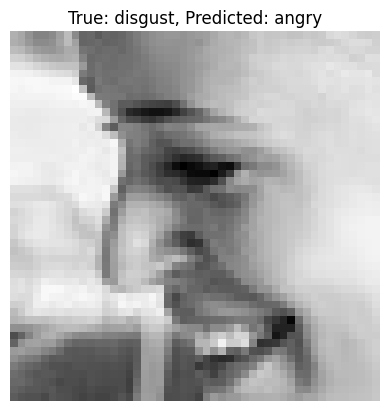

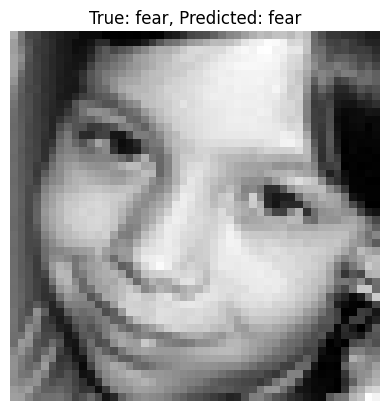

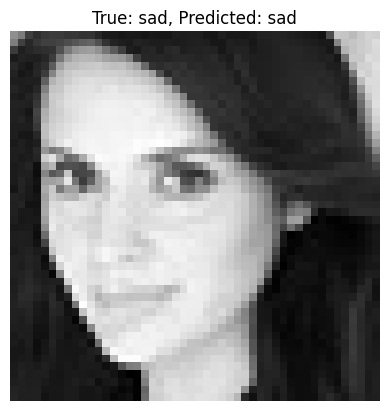

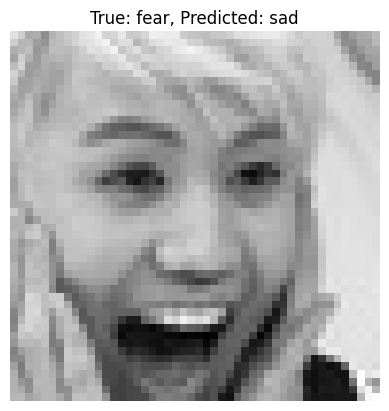

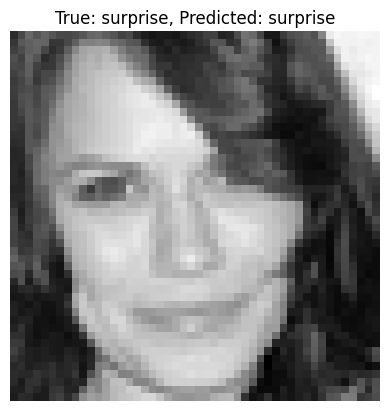

In [ ]:

# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original, indices=None, num_samples=5):
    y_pred = model.predict(X_test)
    
    # If specific indices not provided, sample random ones
    if indices is None:
        indices = np.random.choice(len(y_test), min(num_samples, len(y_test)), replace=False)
    
    plt.figure(figsize=(15, 3*len(indices)))
    
    for i, idx in enumerate(indices):
        plt.subplot(len(indices), 1, i+1)
        original_image = X_original[idx].reshape(48, 48)
        plt.imshow(original_image, cmap='gray')
        
        correct = y_test[idx] == y_pred[idx]
        color = 'green' if correct else 'red'
        
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}",
                  color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, X_test_selected, y_test, label_encoder, X_original)


In [ ]:

# Save the final model
model_file = "improved_knn_model.pkl"
with open(model_file, "wb") as f:
    dump((best_model, pca, scaler, selector, label_encoder, best_params), f, protocol=5)
print(f"Model saved to {model_file}")

# To load and use the model later:
# with open(model_file, "rb") as f:
#     best_model, pca, scaler, selector, label_encoder, best_params = load(f)
#
# # For new data:
# def predict_new_image(image_path, model, pca, scaler, selector, label_encoder):
#     # Load and preprocess image
#     image = Image.open(image_path).convert('L')
#     image = image.resize((48, 48))
#     flat_image = np.array(image).flatten() / 255.0
#     
#     # Apply transformations
#     transformed = pca.transform([flat_image])
#     transformed = scaler.transform(transformed)
#     transformed = selector.transform(transformed)
#     
#     # Predict
#     prediction = model.predict(transformed)
#     label = label_encoder.inverse_transform(prediction)[0]
#     
#     return label

NameError: name 'pickle' is not defined